In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sys
import os
import PIL.Image as pil
sys.path.append('../pba-signet/pba')
from utils import *
import shutil
import matplotlib as mpl
import matplotlib.cm as cm

In [2]:
path = "/ceph/amanraj/data/"
kitti_raw = path + "kitti_raw_eigen_test"
test_file = kitti_raw + "/test_files_eigen.txt"
gt_path = path + "kitti_eigen_gt/gt_depth.npy"
gt_path_interp = path + "kitti_eigen_gt/gt_depth_interp.npy"

In [3]:
pred_path = "/ceph/amanraj/results/paper/train_hp_search-5kt2-max-25q-mono2/policy1_run1/checkpoint_16/predictions/pred_all.npy"

In [4]:
 def setup_evaluation(gt_path):
    # self.gt_path: /path/to/gt_depth.npy or /path/to/gt_interp_depth.npy
    loaded_gt_depths = np.load(gt_path)
    num_test = len(loaded_gt_depths)
    gt_depths = []

    for t_id in range(num_test):
        depth = loaded_gt_depths[t_id]
        gt_depths.append(depth.astype(np.float32))

    return gt_depths

In [5]:
 def read_test_files(dataset_dir):
    """
    Read test files for depth estimation
    :param dataset_dir: root path of kitti dataset
    :return: read test files with kitti root path added as prefix
    """
    with open(test_file, 'r') as f:
        test_files = f.readlines()
        test_files = [t.rstrip() for t in test_files]
        test_files = [os.path.join(dataset_dir, t) for t in test_files]

    return test_files

In [6]:
gt_depths = setup_evaluation(gt_path_interp)
pred_depths = setup_evaluation(pred_path)
test_files = read_test_files(kitti_raw)

In [7]:
def read_file(idx):
    fname = test_files[idx]
    print("reading file: {}".format(fname))
    fh = open(fname, 'rb')
    raw_im = pil.open(fh)

    scaled_im = raw_im
    #scaled_im = raw_im.resize((412, 126), pil.ANTIALIAS)
    scaled_im = np.array(scaled_im, dtype='float32') / 255.0

    gt_depth = gt_depths[idx]
    pred_depth = pred_depths[idx]
    
    return scaled_im, pred_depth, gt_depth


reading file: /ceph/amanraj/data/kitti_raw_eigen_test/2011_09_26/2011_09_26_drive_0064_sync/image_02/data/0000000330.png


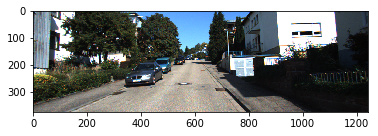

In [68]:
img, pred, _ = read_file(np.random.randint(0, len(test_files)))
plt.imshow(img)

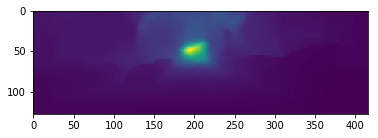

In [69]:
plt.imshow(pred)

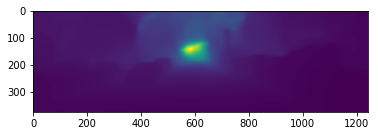

In [70]:
orig_h, orig_w, _ = img.shape
pred_resize = cv2.resize(pred, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)
plt.imshow(pred_resize)

In [71]:
def save_disparity_img(pred):
    disp_resized_np = 1. / pred
    # Saving colormapped depth image
    vmax = np.percentile(disp_resized_np, 95)
    normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
    im = pil.fromarray(colormapped_im)
    return im

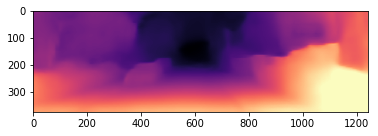

In [72]:
plt.imshow(save_disparity_img(pred_resize))

In [73]:
def scale_depth_disp(pred):  # TODO
    """
    Scale predicted depth and disparity from monodepth2
    """
    max_depth = 80
    min_depth = 1e-3
    
    disp = 1. / pred
    min_disp = 1. / max_depth
    max_disp = 1. / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * ((disp - np.min(disp))/(np.max(disp)-np.min(disp)))
    scaled_depth = 1. / scaled_disp

    return scaled_disp, scaled_depth

In [74]:
_, pred_ = scale_depth_disp(pred_resize)

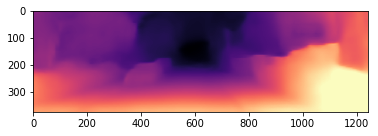

In [75]:
plt.imshow(save_disparity_img(pred_))

In [76]:
img.shape

(375, 1242, 3)